In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import pandas as pd
link = 'https://drive.google.com/open?id=1xT20kiC6bhWPps_uuB_5Jty5I_LbDevc'
id = link.split("=")[1]

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('pre_processing.csv')  
featuresdf = pd.read_csv('pre_processing.csv')
# Dataset is now stored in a Pandas Dataframe

In [3]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Convert features and corresponding classification labels into numpy arrays
X = featuresdf.loc[:,['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
                     'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18',
                     'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27',
                     'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36',
                     'feature_37', 'feature_38', 'feature_39']].values
X = np.array(X)
y = np.array(featuresdf.label.tolist())
print(y)
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))
print(yy)
# split the dataset 
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2)

Using TensorFlow backend.


['keyboard' 'keyboard' 'keyboard' ... 'silence' 'silence' 'keyboard']
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [4]:
yDf = pd.DataFrame({'label': y})
yDf["label"].value_counts()

silence         2000
conversation    2000
keyboard        1966
Name: label, dtype: int64

### Initial model architecture - MLP

We will start with constructing a Multilayer Perceptron (MLP) Neural Network using Keras and a Tensorflow backend. 

Starting with a `sequential` model so we can build the model layer by layer. 

We will begin with a simple model architecture, consisting of three layers, an input layer, a hidden layer and an output layer. All three layers will be of the `dense` layer type which is a standard layer type that is used in many cases for neural networks. 

The first layer will receive the input shape. As each sample contains 40 MFCCs (or columns) we have a shape of (1x40) this means we will start with an input shape of 40. 

The first two layers will have 256 nodes. The activation function we will be using for our first 2 layers is the `ReLU`, or `Rectified Linear Activation`. This activation function has been proven to work well in neural networks.

We will also apply a `Dropout` value of 50% on our first two layers. This will randomly exclude nodes from each update cycle which in turn results in a network that is capable of better generalisation and is less likely to overfit the training data.

Our output layer will have 10 nodes (num_labels) which matches the number of possible classifications. The activation is for our output layer is `softmax`. Softmax makes the output sum up to 1 so the output can be interpreted as probabilities. The model will then make its prediction based on which option has the highest probability.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import backend as K
from sklearn import metrics

num_labels = yy.shape[1]
filter_size = 2
input_shape = len(X[0])

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(input_shape,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

#### Métricas personalizadas: especificidad, sensibilidad y f1 score


In [0]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m], optimizer='adam')
# Display model architecture summary 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               10496     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [0]:
import os
if not os.path.exists('./saved_models'):
    os.makedirs('saved_models')

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import time

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
early_stopper = EarlyStopping(monitor='val_loss', patience=20)

start = time.time()
hist = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_split=0.2, callbacks=[checkpointer, early_stopper], verbose=1)
duration = time.time() - start
print("Training completed in time (s): ", duration)

Train on 3817 samples, validate on 955 samples
Epoch 1/100
3817/3817 [==============================] - 3s 667us/step - loss: 6.9749 - accuracy: 0.7569 - f1_m: 0.7582 - precision_m: 0.7583 - recall_m: 0.7581 - val_loss: 0.3215 - val_accuracy: 0.9885 - val_f1_m: 0.9883 - val_precision_m: 0.9883 - val_recall_m: 0.9883

Epoch 00001: val_loss improved from inf to 0.32150, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 2/100
3817/3817 [==============================] - 1s 175us/step - loss: 0.6356 - accuracy: 0.9521 - f1_m: 0.9523 - precision_m: 0.9523 - recall_m: 0.9523 - val_loss: 0.1244 - val_accuracy: 0.9927 - val_f1_m: 0.9925 - val_precision_m: 0.9925 - val_recall_m: 0.9925

Epoch 00002: val_loss improved from 0.32150 to 0.12439, saving model to saved_models/weights.best.basic_mlp.hdf5
Epoch 3/100
3817/3817 [==============================] - 1s 176us/step - loss: 0.3283 - accuracy: 0.9728 - f1_m: 0.9729 - precision_m: 0.9729 - recall_m: 0.9729 - val_loss: 0.1102 - val_a

In [10]:
ts = time.time()
model.save("MLP_" + str(ts).split('.')[0] + ".h5")
print("Saved model to disk")

Saved model to disk


### Curvas de aprendizaje

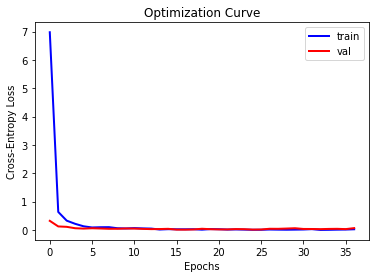

In [11]:
import matplotlib.pyplot as plt

#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('Optimization Curve')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

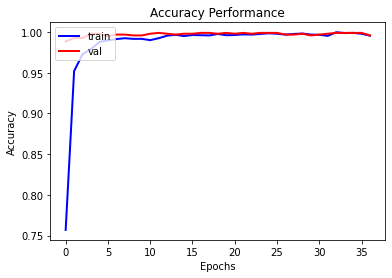

In [12]:
plt.figure()
plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('Accuracy Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(loc='upper left')
plt.show()

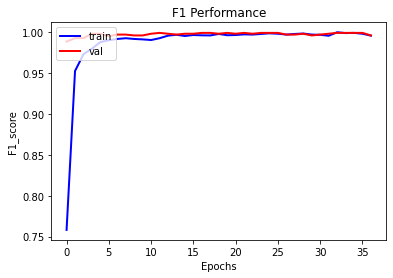

In [13]:
plt.figure()
plt.plot(hist.history['f1_m'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_f1_m'], lw=2.0, color='r', label='val')
plt.title('F1 Performance')
plt.xlabel('Epochs')
plt.ylabel('F1_score')

plt.legend(loc='upper left')
plt.show()

In [0]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)

In [15]:
print(loss, accuracy, f1_score, precision, recall)

0.056820201942681225 0.9941373467445374 0.9942434430122375 0.9942434430122375 0.9942434430122375


In [0]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(x_test)
c_m = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

In [17]:
print(c_m)

[[416   2   2]
 [  1 399   2]
 [  0   0 372]]


In [18]:
import plotly.express as px
fig = px.imshow(c_m)
fig.show()

In [19]:
import plotly.figure_factory as ff

z = c_m

x = ['conversation', 'keyboard', 'air conditioning']
y =  ['conversation', 'keyboard', 'air conditioning']

# change each element of z to type string for annotations
z_text = [[str(y) for y in x] for x in z]

# set up figure 
fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()